In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g`. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import spacy
import nltk
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [20]:
TRAIN_PATH = r"C:\Users\raksh\Desktop\bcc-news-classification\bcc-news-classification\data\BBC News Train.csv"

In [21]:
df = pd.read_csv(TRAIN_PATH)

In [22]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


**Checking number of unique articles in training set**

In [27]:
df.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [29]:
#we will remove duplicate values from training data

In [30]:
df.Category.value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

<AxesSubplot: ylabel='Category'>

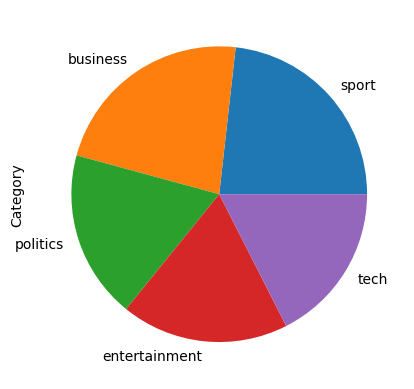

In [31]:
df.Category.value_counts().plot(kind="pie")

In [32]:
#data is almost balanced

In [33]:
duplicates = df[(df["Text"].duplicated() == True)]

print (duplicates.shape)

(50, 3)


In [34]:
duplicates["Category"].value_counts()

tech             27
entertainment    10
politics          8
sport             4
business          1
Name: Category, dtype: int64

<AxesSubplot: ylabel='Category'>

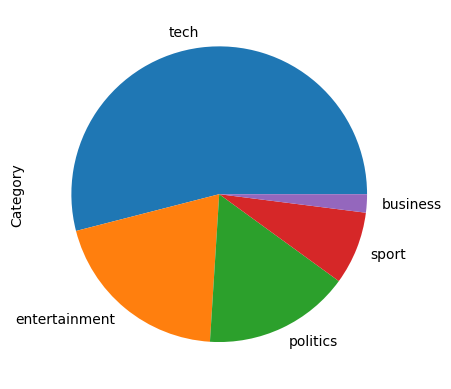

In [35]:
duplicates["Category"].value_counts().plot(kind="pie",)

In [36]:
# we need to handel these duplicate values

In [37]:
# dropinng the duplicate values

In [38]:
df= df.drop_duplicates(subset=['Text'])

In [39]:
duplicates = df[(df["Text"].duplicated() == True)]

duplicates["Category"].value_counts()

Series([], Name: Category, dtype: int64)

# Text-processing

In [40]:
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def preprocessDataset(train_text):
       
    #word tokenization using text-to-word-sequence
    train_text= str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
        
    #stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
        
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
        
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
       
        
    #--Stemming--
    stemmer= PorterStemmer()

    stem_input=nltk.word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
        
        
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
        
    return lem_text

In [41]:
df['Clean_Text'] = df['Text'].apply(preprocessDataset)

In [42]:
df['category_id'] = df['Category'].factorize()[0]

#View first 10 entries of category_id, as a sanity check
df['category_id'][0:10]
df.head(20)

,ArticleId,Text,Category,Clean_Text,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex bos launch defenc lawyer defend fo...,0
1,154,german business confidence slides german busin...,business,german busi confid slide german busi confid fe...,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indic econom gloom citizen major nati...,0
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyl govern mobil choic faster well funkie...,1
4,917,enron bosses in $168m payout eighteen former e...,business,enron bos m payout eighteen former enron direc...,0
5,1582,howard truanted to play snooker conservative...,politics,howard truant play snooker conserv leader mich...,2
6,651,wales silent on grand slam talk rhys williams ...,sport,wale silent grand slam talk rhi william say wa...,3
7,1797,french honour for director parker british film...,entertainment,french honour director parker british film dir...,4
8,2034,car giant hit by mercedes slump a slump in pro...,business,car giant hit merced slump slump profit luxuri...,0
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,focker fuel festiv film chart comedi meet fock...,4


In [43]:
category_id_df = df [['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df

,Category,category_id
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [44]:
df.shape

(1440, 5)

In [45]:
Feature=df["Clean_Text"]
target=df["category_id"]

In [46]:
# spliting data

X_train, X_test, y_train, y_test= train_test_split(Feature,target, test_size=0.25, random_state=0)

In [76]:
#Vectorizing data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english') #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(X_train.values.astype('U'))
Xtest_tfidf = tfidf_vect.transform(X_test.values.astype('U'))
count_vect = CountVectorizer(min_df=5, encoding='latin-1', ngram_range=(1, 2), stop_words='english') # CountVectorizer
Xtrain_count = count_vect.fit_transform(X_train.values.astype('U'))
Xtest_count = count_vect.transform(X_test.values.astype('U'))

**model building**

# LogisticRegression

In [80]:
log_model_=LogisticRegression(n_jobs=-1)

In [81]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [100, 1000, 10000],
              'multi_class': ['ovr', 'multinomial']}

In [82]:
from sklearn.model_selection import GridSearchCV


In [83]:
import warnings
warnings.filterwarnings("ignore")

In [84]:
Grid_model_=GridSearchCV(log_model_,param_grid=parameters,cv=5)

In [85]:
Grid_model_.fit(Xtrain_tfidf,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 1000, 10000],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [86]:
Grid_model_.best_params_

{'C': 10,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [87]:
log_model=LogisticRegression(**Grid_model_.best_params_)

In [88]:
log_model.fit(Xtrain_tfidf,y_train)

LogisticRegression(C=10, multi_class='multinomial', solver='newton-cg')

In [89]:
# traing accuracy
log_model.score(Xtrain_tfidf,y_train)

1.0

In [90]:
y_pred1 = log_model.predict(Xtest_tfidf)

In [91]:
# Confusion Matrix
conf_mat_ = confusion_matrix(y_test,y_pred1)
conf_mat_

array([[84,  2,  0,  0,  0],
       [ 0, 63,  0,  0,  1],
       [ 1,  1, 57,  1,  1],
       [ 0,  0,  0, 78,  0],
       [ 1,  1,  0,  0, 69]], dtype=int64)

In [93]:
# testing accuracy
accuracy = accuracy_score(y_test,y_pred1)
accuracy

0.975

model Accuracy : 97.5000%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        86
           1       0.94      0.98      0.96        64
           2       1.00      0.93      0.97        61
           3       0.99      1.00      0.99        78
           4       0.97      0.97      0.97        71

    accuracy                           0.97       360
   macro avg       0.98      0.97      0.97       360
weighted avg       0.98      0.97      0.97       360



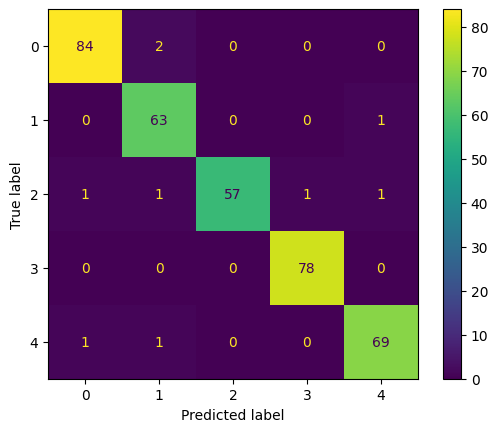

In [130]:
def confusion_matrix(X_test,y_test,y_test_pred):
    accuracy_score_ = accuracy_score(y_test, y_test_pred)
    print("model Accuracy :", "{:.4f}%".format(100*accuracy_score_))

    from sklearn.metrics import classification_report
    print (classification_report(y_test,y_test_pred))


    import matplotlib.pyplot as plt
    import numpy
    from sklearn import metrics
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

    cm_display.plot()
    plt.show()

confusion_matrix(Xtest_tfidf,y_test,y_pred1)

In [129]:
from joblib import Parallel, delayed
import joblib
  
# Save the model as a pickle in a file
joblib.dump(log_model, 'LOG_Tuned.pkl')

['LOG_Tuned.pkl']

# SGD

In [95]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, make_scorer

In [96]:
model = SGDClassifier()
# Define the scoring metric
scoring_metric = make_scorer(accuracy_score)

In [ ]:
parameters = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1, 1.0],
    "penalty" : ["l2", "l1", "none"],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'max_iter': [100, 500, 1000, 5000],
}


In [110]:
# Define the hyperparameters to be tuned
parameters = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1, 1.0],
    "penalty" : ["l2", "l1", "none"],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'max_iter': [100, 500, 1000, 5000],
}

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring_metric, cv=5)



In [111]:
# Fit the GridSearchCV object to the training data
grid_search.fit(Xtrain_tfidf,y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'loss': ['hinge', 'log', 'squared_hinge',
                                  'modified_huber'],
                         'max_iter': [100, 500, 1000, 5000],
                         'penalty': ['l2', 'l1', 'none']},
             scoring=make_scorer(accuracy_score))

In [112]:
grid_search.best_params_

{'alpha': 0.0001,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 5000,
 'penalty': 'l2'}

In [113]:
SGD_Classifier=SGDClassifier(**grid_search.best_params_)

In [116]:
SGD_Classifier.fit(Xtrain_tfidf,y_train)

SGDClassifier(max_iter=5000)

In [117]:
y_pred2 = SGD_Classifier.predict(Xtest_tfidf)

In [118]:
# Confusion Matrix
conf_mat_ = confusion_matrix(y_test,y_pred2)
conf_mat_

array([[84,  2,  0,  0,  0],
       [ 0, 64,  0,  0,  0],
       [ 2,  1, 56,  1,  1],
       [ 0,  0,  0, 78,  0],
       [ 0,  0,  0,  1, 70]], dtype=int64)

In [119]:
# testing accuracy
accuracy = accuracy_score(y_test,y_pred2)
accuracy

0.9777777777777777

In [122]:
from joblib import Parallel, delayed
import joblib
  
# Save the model as a pickle in a file
joblib.dump(SGD_Classifier, 'SGD_tuned.pkl')

['SGD_tuned.pkl']

In [125]:
def confusion_matrix(X_test,y_test,y_test_pred):
    accuracy_score_ = accuracy_score(y_test, y_test_pred)
    print("model Accuracy :", "{:.4f}%".format(100*accuracy_score_))

    from sklearn.metrics import classification_report
    print (classification_report(y_test,y_test_pred))


    import matplotlib.pyplot as plt
    import numpy
    from sklearn import metrics
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

    cm_display.plot()
    plt.show()

model Accuracy : 97.7778%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        86
           1       0.96      1.00      0.98        64
           2       1.00      0.92      0.96        61
           3       0.97      1.00      0.99        78
           4       0.99      0.99      0.99        71

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



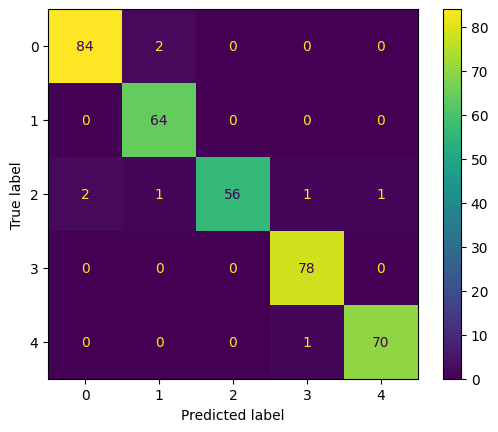

In [128]:
confusion_matrix(Xtest_tfidf,y_test, y_pred2)

# Pipeline

In [190]:
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline(steps=[('Tf-idf',TfidfVectorizer(sublinear_tf=True, 
                                                    min_df=5, norm='l2',
                                                      encoding='latin-1', 
                                                      ngram_range=(1, 2),
                                                        stop_words='english')),
                          ('lr', LogisticRegression(C= 10, 
                                                    max_iter= 100,
                                                    multi_class= 'multinomial',
                                                    penalty= 'l2',
                                                    solver= 'newton-cg'))])

In [191]:
pipe_lr.fit(X_train, y_train)


Pipeline(steps=[('Tf-idf',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), stop_words='english',
                                 sublinear_tf=True)),
                ('lr',
                 LogisticRegression(C=10, multi_class='multinomial',
                                    solver='newton-cg'))])

In [141]:
# Check Accuracy
pipe_lr.score(X_test, y_test)

0.975

In [185]:
# Save Model & Pipeline
import joblib
pipeline_file = open("pipe_lr.pkl","wb")
joblib.dump(pipe_lr,pipeline_file)
pipeline_file.close()

# Example from IndiaNews
### It was tagged under ENTERTAINMENT in the website, now lets check how oue model performs.
---------------------------------------------


<b>Priyanka Chopra goes out of her way to make fan fighting cancer feel comfortable at Jonas Brothers’ concert, hugs them: ‘She relates’</b>

Priyanka Chopra made the night special for a fan and her mother, who is fighting cancer, at the Jonas Brothers’ concert on Sunday. The fan took to social media to give a detailed account of PeeCee’s kind gesture towards them, stating how she is truly grateful for her kindness. “So, I knew the @jonasbrothers concert would be awesome. And it was. What I did not expect was that I would get to meet Priyanka Chopra Jonas and have a night I will never forget, and am so grateful for. So it’s STORY TIME. Thank you @priyankachopra!,” the social media user named Lisa Dawn tweeted. She followed it up with what transpired in the evening at the concert, sharing how she had bought the tickets for her mother, who is a JoBros fan. She added how they were standing near the VIP section when Priyanka walked by them. Lisa added that while she doesn’t know what sparked it all but given her mother is currently bald because of her treatment, she assumed that gave it away. “I know Priyanka’s dad passed from cancer, so I’m sure she relates,” she wrote. The social media user then wrote about how a tour staff came up to them and asked if they would like to sit with them in the VIP section. “And we were like, “WHAT???” and he was basically like, “Mrs. Jonas would like you to come up here.” So… we did.” As Lisa said that she and her mother got comfortable, the global star came up to them, introduced herself and made them comfortable. She said the comfortable seat made it so much easier for her mother to enjoy the show. This wasn’t the end of Priyanka’s big heart move as she then gifted the fans some cool merchandise. “When it was getting close to the end and Priyanka had to leave, she came back over and gave us a bundle of merchandise (sweatshirts and hats), then hugged my mom and I both and talked again for a moment. We found out later that she specifically asked the tour staff to get some merch and bring it over so she could do that. I know I must have said thank you fifty times, and we told her how much it meant to us. I don’t know why she did it, but I do know that she didn’t have to do ANYTHING at all. She was just there to enjoy her husband’s show and took time out to make the night extra special for two complete strangers. That’s genuine goodness right there,” the fan wrote. She added that they did not take selfies as that was a ‘human moment’ more than a celeb moment for them. She also thanked the superstar for her kindness and making the night special for her.

In [173]:
ex1 = """Priyanka Chopra made the night special for a fan and her mother, who is fighting cancer, at the Jonas Brothers’ concert on Sunday. The fan took to social media to give a detailed account of PeeCee’s kind gesture towards them, stating how she is truly grateful for her kindness. “So, I knew the @jonasbrothers concert would be awesome. And it was. What I did not expect was that I would get to meet Priyanka Chopra Jonas and have a night I will never forget, and am so grateful for. So it’s STORY TIME. Thank you @priyankachopra!,” the social media user named Lisa Dawn tweeted.

She followed it up with what transpired in the evening at the concert, sharing how she had bought the tickets for her mother, who is a JoBros fan. She added how they were standing near the VIP section when Priyanka walked by them. Lisa added that while she doesn’t know what sparked it all but given her mother is currently bald because of her treatment, she assumed that gave it away. “I know Priyanka’s dad passed from cancer, so I’m sure she relates,” she wrote.

The social media user then wrote about how a tour staff came up to them and asked if they would like to sit with them in the VIP section. “And we were like, “WHAT???” and he was basically like, “Mrs. Jonas would like you to come up here.” So… we did.” As Lisa said that she and her mother got comfortable, the global star came up to them, introduced herself and made them comfortable. She said the comfortable seat made it so much easier for her mother to enjoy the show.

This wasn’t the end of Priyanka’s big heart move as she then gifted the fans some cool merchandise. “When it was getting close to the end and Priyanka had to leave, she came back over and gave us a bundle of merchandise (sweatshirts and hats), then hugged my mom and I both and talked again for a moment. We found out later that she specifically asked the tour staff to get some merch and bring it over so she could do that. I know I must have said thank you fifty times, and we told her how much it meant to us. I don’t know why she did it, but I do know that she didn’t have to do ANYTHING at all. She was just there to enjoy her husband’s show and took time out to make the night extra special for two complete strangers. That’s genuine goodness right there,” the fan wrote.

She added that they did not take selfies as that was a ‘human moment’ more than a celeb moment for them. She also thanked the superstar for her kindness and making the night special for her."""
pipe_lr.predict([ex1])

array([4], dtype=int64)

In [170]:
category_id_df

,Category,category_id
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [174]:
## Model predicted Entertainment as well

In [188]:
from sklearn.pipeline import Pipeline
pipe_SGD = Pipeline(steps=[('Tf-idf',TfidfVectorizer(sublinear_tf=True,
                                                      min_df=5, norm='l2',
                                                        encoding='latin-1',
                                                          ngram_range=(1, 2),
                                                            stop_words='english')),
                          ('SGD_Classifier', SGDClassifier(alpha = 0.0001, 
                                                           learning_rate = 'optimal',
                                                              loss = 'hinge',
                                                                max_iter = 5000,
                                                                  penalty = 'l2'))])

In [189]:
pipe_SGD.fit(X_train, y_train)


Pipeline(steps=[('Tf-idf',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), stop_words='english',
                                 sublinear_tf=True)),
                ('SGD_Classifier', SGDClassifier(max_iter=5000))])

In [184]:
# Save Model & Pipeline
import joblib
pipeline_file = open("pipe_SGD.pkl","wb")
joblib.dump(pipe_SGD,pipeline_file)
pipeline_file.close()

In [193]:
#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<  END  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>